Optimization terminated successfully.
         Current function value: 203.479890
         Iterations: 95
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 156.122133
         Iterations: 86
         Function evaluations: 161


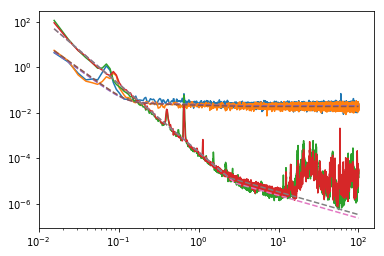

In [40]:
import dtt2hdf
import matplotlib.pyplot as plt
import numpy as np
items = dtt2hdf.read_diaggui('./data/SR2_IP_noise_20200720a.xml')
f = items.results.PSD['K1:VIS-SR2_IP_BLEND_ACCL_IN1'].FHz
lvdtl = items.results.PSD['K1:VIS-SR2_IP_BLEND_LVDTL_IN1'].PSD[0]
lvdtt = items.results.PSD['K1:VIS-SR2_IP_BLEND_LVDTT_IN1'].PSD[0]
accl = items.results.PSD['K1:VIS-SR2_IP_BLEND_ACCL_IN1'].PSD[0]
acct = items.results.PSD['K1:VIS-SR2_IP_BLEND_ACCT_IN1'].PSD[0]
mask = f>=1e-2
f = f[mask]
lvdtl = lvdtl[mask]
lvdtt = lvdtt[mask]
accl = accl[mask]
acct = acct[mask]
plt.loglog(f,lvdtl)
plt.loglog(f,lvdtt)
plt.loglog(f,accl)
plt.loglog(f,acct)
from kontrol.model import *
from kontrol import quad_sum

def low_noise_model(f, seis_N0, lvdt_N0, lvdt_fc):
    noise = quad_sum(seis_N0/f**2.5, lvdt_noise(f, lvdt_N0, lvdt_fc, exp=[-0.1,0]))
    return(noise)

# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
low_noise_weight = np.ones_like(f)
for i in range(len(low_noise_weight)):
    if f[i]>0.03 and f[i]<0.2:
        low_noise_weight[i]=0
# lvdtl_args = noise_fit(low_noise_model, f, lvdtl, weight = low_noise_weight)
# lvdtt_args = noise_fit(low_noise_model, f, lvdtt, weight = low_noise_weight)
plt.loglog(f, low_noise_model(f, *lvdtl_args), '--')
plt.loglog(f, low_noise_model(f, *lvdtt_args), '--')

geo_noise_weight = np.ones_like(f)
# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
for i in range(len(geo_noise_weight)):
    if (f[i]>0.03 and f[i]<0.2) or (f[i]>0.3 and f[i]<1.5)or f[i]>10:
        geo_noise_weight[i]=0

def high_noise_model(f, geo_N0, geo_fc):
    return(geophone_noise(f, geo_N0, geo_fc, exp=[-3,-1]))
geol_args = noise_fit(high_noise_model, f, accl, weight = geo_noise_weight)
geot_args = noise_fit(high_noise_model, f, acct, weight = geo_noise_weight)
plt.loglog(f, high_noise_model(f, *geol_args), '--')
plt.loglog(f, high_noise_model(f, *geot_args), '--')

# plt.loglog(f, low_noise_model(f, 1e-6, 1e-6, 1))
# data=np.loadtxt('./data/SR2_IP_noise_20200720a.txt')
# f, accltxt = data[:,0], data[:,4]
# plt.loglog(f,accltxt)
# len(accltxt)
# data
# plt.semilogx(np.angle(items.results.TF['K1:VIS-SR2_IP_BLEND_ACCL_IN1'].CSD[2]))

In [68]:
from kontrol.filter import (optimize_complementary_filter, 
    complementary_modified_sekiguchi, complementary_sekiguchi, complementary_lucia)
res = optimize_complementary_filter(
    complementary_modified_sekiguchi,
    spectra=[low_noise_model(f,*lvdtl_args),high_noise_model(f,*geol_args)],
    f=f,
#     bounds=[(0.01,10),(0.01,10),(0.01,10),(0.01,10),(0.5,1000),(0.01,10),(0.5,1000)],
    x0=[0.32,0.32,0.32,0.32]
    )
# res.x/2/np.pi

Optimizing with scipy.optimize.minimize
Done. Time taken: 21.30 s The 2-norm is 5.23 unit


In [66]:
res.x/2/np.pi

array([6.34813157e-02, 5.91889458e-02, 4.82634758e-02, 1.59154943e-03,
       6.04568845e+01, 6.40529907e-02, 5.85599424e+01])

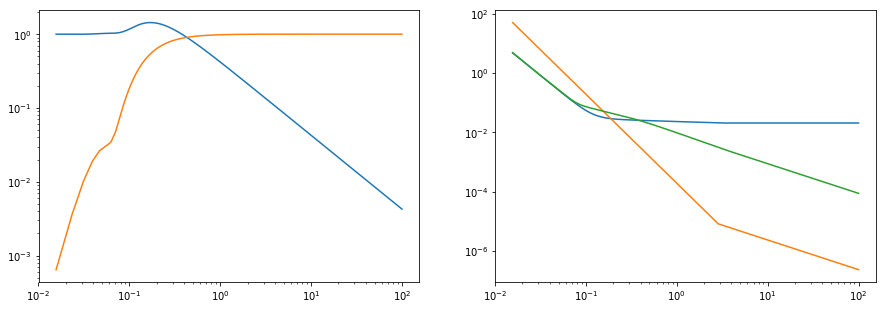

In [69]:
lpfl, hpfl = complementary_modified_sekiguchi(res.x)
# lpfl, hpfl = complementary_lucia(res.x)
# lpfl, hpfl = complementary_sekiguchi(res.x)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.loglog(f, abs(lpfl.horner(2*np.pi*1j*f)[0][0]))
plt.loglog(f, abs(hpfl.horner(2*np.pi*1j*f)[0][0]))
plt.subplot(122)
plt.loglog(f, low_noise_model(f,*lvdtl_args))
plt.loglog(f, high_noise_model(f,*geol_args))
plt.loglog(f, quad_sum(abs(lpfl.horner(2*np.pi*1j*f)[0][0])*low_noise_model(f,*lvdtl_args),
                       abs(hpfl.horner(2*np.pi*1j*f)[0][0])*high_noise_model(f,*geol_args)))

In [73]:
lpfl, hpfl

(
   2.681 s^6 + 3.312 s^5 + 2.362 s^4 + 0.9616 s^3 + 0.2349 s^2 + 0.03188 s + 0.001854
 ---------------------------------------------------------------------------------------
 s^7 + 2.85 s^6 + 3.481 s^5 + 2.362 s^4 + 0.9616 s^3 + 0.2349 s^2 + 0.03188 s + 0.001854,
 
                      s^7 + 0.1691 s^6 + 0.1687 s^5 + 6.687e-10 s^4
 ---------------------------------------------------------------------------------------
 s^7 + 2.85 s^6 + 3.481 s^5 + 2.362 s^4 + 0.9616 s^3 + 0.2349 s^2 + 0.03188 s + 0.001854)

In [70]:
res = optimize_complementary_filter(
    complementary_modified_sekiguchi,
    spectra=[low_noise_model(f,*lvdtt_args),high_noise_model(f,*geot_args)],
    f=f,
#     bounds=[(0.01,10),(0.01,10),(0.01,10),(0.01,10),(0.5,1000),(0.01,10),(0.5,1000)],
    x0=[0.32,0.32,0.32,0.32]
    )

Optimizing with scipy.optimize.minimize
Done. Time taken: 22.06 s The 2-norm is 5.89 unit


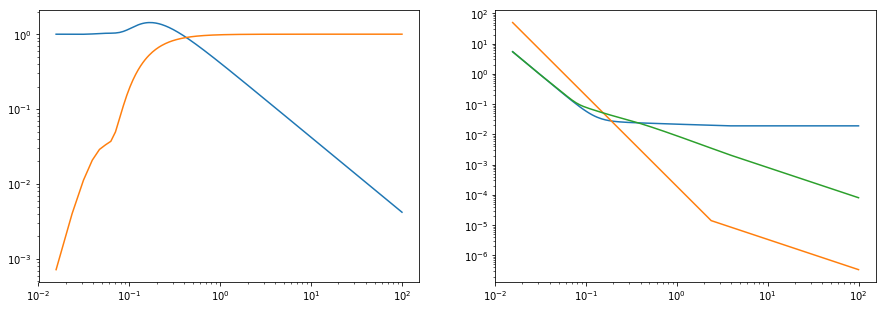

In [71]:
lpft, hpft = complementary_modified_sekiguchi(res.x)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.loglog(f, abs(lpft.horner(2*np.pi*1j*f)[0][0]))
plt.loglog(f, abs(hpft.horner(2*np.pi*1j*f)[0][0]))
plt.subplot(122)
plt.loglog(f, low_noise_model(f,*lvdtt_args))
plt.loglog(f, high_noise_model(f,*geot_args))
plt.loglog(f, quad_sum(abs(lpft.horner(2*np.pi*1j*f)[0][0])*low_noise_model(f,*lvdtt_args),
                       abs(hpft.horner(2*np.pi*1j*f)[0][0])*high_noise_model(f,*geot_args)))

In [72]:
lpft


    2.64 s^6 + 3.22 s^5 + 2.272 s^4 + 0.913 s^3 + 0.2202 s^2 + 0.02949 s + 0.001693
---------------------------------------------------------------------------------------
s^7 + 2.813 s^6 + 3.392 s^5 + 2.272 s^4 + 0.913 s^3 + 0.2202 s^2 + 0.02949 s + 0.001693

In [74]:
lpft, hpft

(
     2.64 s^6 + 3.22 s^5 + 2.272 s^4 + 0.913 s^3 + 0.2202 s^2 + 0.02949 s + 0.001693
 ---------------------------------------------------------------------------------------
 s^7 + 2.813 s^6 + 3.392 s^5 + 2.272 s^4 + 0.913 s^3 + 0.2202 s^2 + 0.02949 s + 0.001693,
 
                      s^7 + 0.1731 s^6 + 0.1723 s^5 + 2.128e-09 s^4
 ---------------------------------------------------------------------------------------
 s^7 + 2.813 s^6 + 3.392 s^5 + 2.272 s^4 + 0.913 s^3 + 0.2202 s^2 + 0.02949 s + 0.001693)